# Load Data

In [ ]:

import os
import zipfile
import glob
from PIL import Image

os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"

import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from pathlib import Path
from google.colab import drive

drive.mount('/content/drive')

zip_path = "/content/drive/MyDrive/img_align_celeba.zip"
extract_dir = "/content/celeba"
img_size  = 32
batch_size = 128
num_workers = 6
os.makedirs(extract_dir, exist_ok=True)


def _has_any_image(root: Path) -> bool:
    exts = ("*.jpg", "*.jpeg", "*.png")
    for ext in exts:
        if any(root.rglob(ext)):
            return True
    return False

if not _has_any_image(Path(extract_dir)):
    assert os.path.exists(zip_path), f"No encuentro el zip en {zip_path}"
    with zipfile.ZipFile(zip_path, 'r') as z:
        z.extractall(extract_dir)

exts = ("*.jpg", "*.jpeg", "*.png")
all_paths = []
for ext in exts:
    all_paths += list(Path(extract_dir).rglob(ext))

if not all_paths:
    raise FileNotFoundError(
        f"No encontré imágenes (.jpg/.jpeg/.png) tras extraer {zip_path}.\n"
        f"Revisa manualmente el contenido de {extract_dir}.")

class FlatImageDataset(Dataset):
    def __init__(self, paths, transform=None, skip_broken=True):
        self.paths = sorted(map(str, paths))
        self.transform = transform
        self.skip_broken = skip_broken

        if len(self.paths) == 0:
            raise FileNotFoundError("La lista de imágenes está vacía.")

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        path = self.paths[idx]
        try:
            img = Image.open(path).convert("RGB")
        except Exception as e:
            if self.skip_broken:
                return self.__getitem__((idx + 1) % len(self))
            else:
                raise e
        if self.transform:
            img = self.transform(img)
        return img, 0

transform = transforms.Compose([
    transforms.Resize(178, antialias=True),
    transforms.CenterCrop(178),
    transforms.Resize(img_size, antialias=True),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5]*3, std=[0.5]*3),])

dataset = FlatImageDataset(all_paths, transform=transform)
train_loader = DataLoader(
    dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers,
    pin_memory=True)

print(f"[OK] Imágenes detectadas (recursivo): {len(dataset)}")
print(f"[OK] DataLoader listo: batch_size={batch_size}, img_size={img_size}")

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
import random, numpy as np, torch
from torch.utils.data import DataLoader
from torchvision import transforms as T
from PIL import ImageFile
import datasets as hfds
from datasets import load_dataset

# ---- Robustez I/O ----
ImageFile.LOAD_TRUNCATED_IMAGES = True  # tolera imágenes truncadas

# ---- Seeds reproducibles ----
seed = 1337
random.seed(seed); np.random.seed(seed); torch.manual_seed(seed)
if torch.cuda.is_available(): torch.cuda.manual_seed_all(seed)

# ---- Config ----
DATASET_NAME = "eurecom-ds/celeba-hq-256"
img_size     = 256
batch_size   = 8

# ---- Transforms CPU ----
tfm = T.Compose([
    T.Resize((img_size, img_size)),        # (antialias=True) puede fallar en algunas builds; dejar simple
    T.ToTensor(),
    T.Normalize([0.5]*3, [0.5]*3),
])

# ---- Carga HF dataset y garantiza PIL decode ----
try:
    ds = load_dataset(DATASET_NAME, split="default")
except Exception:
    ds = load_dataset(DATASET_NAME, split="train")
ds = ds.cast_column("image", hfds.Image(decode=True))  # asegura PIL Images

# ---- Transform seguro (batched), tolerante a errores ----
def safe_batched_transform(examples):
    imgs = examples["image"]
    out = []
    for img in imgs:
        try:
            out.append(tfm(img.convert("RGB")))
        except Exception as e:
            # Log mínimo y placeholder neutro
            print(f"[WARN] Imagen defectuosa: {getattr(img, 'filename', 'unknown')} | {e}")
            out.append(torch.zeros(3, img_size, img_size))
    return {"image": out}

ds.set_transform(safe_batched_transform)

# ---- Collate simple ----
def collate_fn(batch):
    x = torch.stack([b["image"] for b in batch], dim=0)
    y = torch.zeros(len(batch), dtype=torch.long)
    return x, y

# ---- Inicializador de workers (evita colisiones de RNG) ----
def w_init(worker_id):
    s = (torch.initial_seed() % 2**32)
    random.seed(s); np.random.seed(s % (2**32 - 1))

# ---- DataLoader SAFE: 2 workers, sin persistencia, prefetch prudente ----
train_loader = DataLoader(
    ds,
    batch_size=batch_size,
    shuffle=True,
    num_workers=4,                # ← como pediste: al menos 2
    pin_memory=True,
    persistent_workers=False,     # activa True cuando veas estable (opcional)
    prefetch_factor=2,
    worker_init_fn=w_init,
    collate_fn=collate_fn,
    timeout=0                     # sin timeout para colas ocupadas
)

# ---- Smoke test rápido ----
print(f"[OK] Total imágenes: {len(ds)} (esperado ~30000)")
xb, yb = next(iter(train_loader))
print("[OK] Batch:", xb.shape, xb.dtype, (xb.min().item(), xb.max().item()))


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/343 [00:00<?, ?B/s]

data/train-00000-of-00007.parquet:   0%|          | 0.00/458M [00:00<?, ?B/s]

data/train-00001-of-00007.parquet:   0%|          | 0.00/454M [00:00<?, ?B/s]

data/train-00002-of-00007.parquet:   0%|          | 0.00/450M [00:00<?, ?B/s]

data/train-00003-of-00007.parquet:   0%|          | 0.00/443M [00:00<?, ?B/s]

data/train-00004-of-00007.parquet:   0%|          | 0.00/438M [00:00<?, ?B/s]

data/train-00005-of-00007.parquet:   0%|          | 0.00/432M [00:00<?, ?B/s]

data/train-00006-of-00007.parquet:   0%|          | 0.00/428M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/30000 [00:00<?, ? examples/s]

[OK] Total imágenes: 30000 (esperado ~30000)
[OK] Batch: torch.Size([8, 3, 256, 256]) torch.float32 (-1.0, 1.0)


# Subset

In [ ]:
import numpy as np
from torch.utils.data import Subset

N = min(100_000, len(dataset))

SEED_SUBSET = 2025
SEED_SHUFFLE = 1337

rng = np.random.default_rng(SEED_SUBSET)
subset_indices = rng.choice(len(dataset), size=N, replace=False)
subset = Subset(dataset, subset_indices.tolist())

g = torch.Generator()
g.manual_seed(SEED_SHUFFLE)

train_loader = DataLoader(
    subset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers,
    pin_memory=True,
    generator=g)

print(f"[OK] Subset listo: {len(subset)} imágenes (de {len(dataset)})")
print(f"[OK] DataLoader listo: batch_size={batch_size}, img_size={img_size}")

In [3]:

imgs, _ = next(iter(train_loader))
imgs.shape

torch.Size([8, 3, 256, 256])

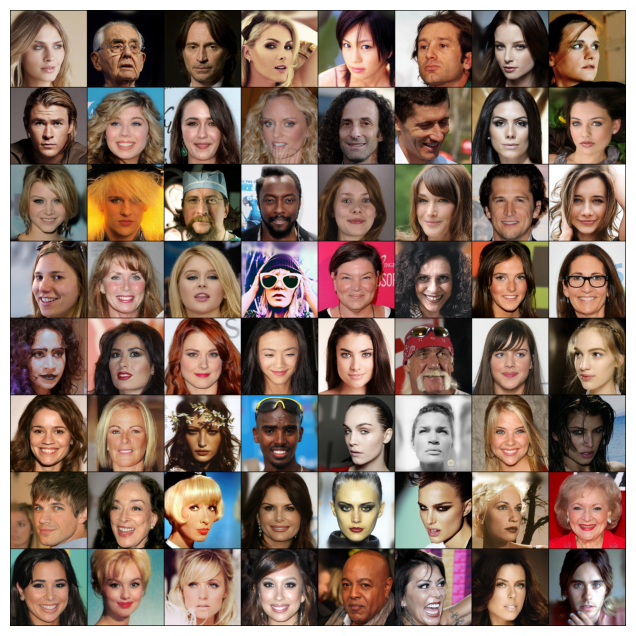

In [ ]:

import matplotlib.pyplot as plt
import torchvision

imgs, _ = next(iter(train_loader))
imgs = (imgs * 0.5) + 0.5
grid = torchvision.utils.make_grid(imgs[:64], nrow=8)

plt.figure(figsize=(8,8))
plt.axis("off")
plt.imshow(grid.permute(1, 2, 0).cpu().numpy())
plt.show()

# Model

In [4]:
import math
from typing import Tuple, Sequence, Set, Optional
import torch
import torch.nn as nn
import torch.nn.functional as F

class SinusoidalPosEmb(nn.Module):
    """Embedding sinusoidal estándar para timesteps (t) -> R^dim."""
    def __init__(self, dim: int):
        super().__init__()
        self.dim = dim

    def forward(self, t: torch.Tensor) -> torch.Tensor:
        half = self.dim // 2
        device = t.device
        emb = math.log(10000) / (half - 1)
        emb = torch.exp(torch.arange(half, device=device) * -emb)
        emb = t.float().unsqueeze(1) * emb.unsqueeze(0)
        emb = torch.cat([emb.sin(), emb.cos()], dim=1)
        if self.dim % 2 == 1:
            emb = F.pad(emb, (0,1))
        return emb


class TimeMLP(nn.Module):
    """Proyecta el embedding sinusoidal a un espacio (time_dim) con activación."""
    def __init__(self, in_dim: int, out_dim: int):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, out_dim),
            nn.SiLU(),
            nn.Linear(out_dim, out_dim),)

    def forward(self, t_emb: torch.Tensor) -> torch.Tensor:
        return self.net(t_emb)  # (B, out_dim)

def group_norm(channels: int, num_groups: int = 32) -> nn.GroupNorm:
    return nn.GroupNorm(num_groups=min(num_groups, channels), num_channels=channels, eps=1e-6, affine=True)

class ResBlock(nn.Module):
    """
    Residual block con GN + SiLU + Conv, condicionado por el embedding temporal.
    Cada bloque puede cambiar el # de canales (in_ch -> out_ch).
    """
    def __init__(self, in_ch: int, out_ch: int, time_dim: int, dropout: float = 0.0):
        super().__init__()
        self.in_ch = in_ch
        self.out_ch = out_ch

        self.norm1 = group_norm(in_ch)
        self.act1  = nn.SiLU()
        self.conv1 = nn.Conv2d(in_ch, out_ch, kernel_size=3, padding=1)

        # Proyección del tiempo al sesgo por canal
        self.time_proj = nn.Sequential(
            nn.SiLU(),
            nn.Linear(time_dim, out_ch))

        self.norm2 = group_norm(out_ch)
        self.act2  = nn.SiLU()
        self.drop  = nn.Dropout(dropout) if dropout > 0 else nn.Identity()
        self.conv2 = nn.Conv2d(out_ch, out_ch, kernel_size=3, padding=1)

        # Skip si cambia número de canales
        self.skip = nn.Identity() if in_ch == out_ch else nn.Conv2d(in_ch, out_ch, kernel_size=1)

    def forward(self, x: torch.Tensor, t_emb: torch.Tensor) -> torch.Tensor:
        h = self.conv1(self.act1(self.norm1(x)))
        # Añadimos conditioning del tiempo como sesgo por canal
        # (B, out_ch) -> (B, out_ch, 1, 1)
        t_bias = self.time_proj(t_emb).unsqueeze(-1).unsqueeze(-1)
        h = h + t_bias
        h = self.conv2(self.drop(self.act2(self.norm2(h))))
        return h + self.skip(x)


class AttnBlock(nn.Module):
    def __init__(self, channels: int, num_heads: int = 4, head_dim: int = 64, p_drop: float = 0.0):
        super().__init__()
        assert channels > 0 and num_heads > 0 and head_dim > 0
        self.channels  = channels
        self.num_heads = num_heads
        self.head_dim  = head_dim
        self.p_drop    = float(p_drop)

        inner = num_heads * head_dim
        self.norm = group_norm(channels)
        self.qkv  = nn.Conv2d(channels, inner * 3, kernel_size=1, bias=False)
        self.proj = nn.Conv2d(inner, channels, kernel_size=1)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        B, C, H, W = x.shape
        N = H * W

        h = self.norm(x)
        qkv = self.qkv(h).reshape(B, 3, self.num_heads, self.head_dim, N)
        q, k, v = qkv.unbind(dim=1)                        # (B, heads, d, N)
        q = q.permute(0, 1, 3, 2).contiguous()             # (B, heads, N, d)
        k = k.permute(0, 1, 3, 2).contiguous()
        v = v.permute(0, 1, 3, 2).contiguous()

        # Dropout dentro de SDPA (solo en training)
        dp = self.p_drop if self.training and self.p_drop > 0.0 else 0.0
        out = torch.nn.functional.scaled_dot_product_attention(
            q, k, v, dropout_p=dp, is_causal=False)

        out = out.permute(0, 1, 3, 2).contiguous().reshape(B, self.num_heads * self.head_dim, H, W)
        out = self.proj(out)
        return x + out

In [5]:
class Downsample(nn.Module):
    """Downsample por factor 2 con conv (stride=2) para evitar aliasing excesivo."""
    def __init__(self, channels: int):
        super().__init__()
        self.conv = nn.Conv2d(channels, channels, kernel_size=3, stride=2, padding=1)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.conv(x)

class Upsample(nn.Module):
    """Upsample ×2 por interpolación + conv (evita checkerboard)."""
    def __init__(self, channels: int):
        super().__init__()
        self.conv = nn.Conv2d(channels, channels, kernel_size=3, padding=1)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = F.interpolate(x, scale_factor=2, mode='nearest')
        return self.conv(x)

class UNetDenoiser(nn.Module):
    """
    U-Net para DDPM (predice ε).
    - in_channels: 3 (RGB)
    - base_channels: canales iniciales (p.ej., 128)
    - channel_mults: multiplicadores por nivel (64->32->16->8->...); p.ej., (1,2,2,2) para 64x64
    - num_res_blocks: # de ResBlocks por resolución en encoder/decoder
    - attn_resolutions: resoluciones (H o W) donde aplicar atención (p.ej., {16, 8})
    - time_dim: dimensión del embedding temporal proyectado
    """
    def __init__(self,
        in_channels: int = 3,
        base_channels: int = 128,
        channel_mults: Sequence[int] = (1, 2, 2, 2), # Cuanto multiplicamos base en cada bloque
        num_res_blocks: int = 2,
        attn_resolutions: Set[int] = frozenset({16, 8}),
        time_embed_dim: int = 512,
        dropout: float = 0.0,
        num_heads: int = 4,
        head_dim: int = 64,
        img_resolution: int = 64):

        super().__init__()

        # Embedding temporal
        self.time_pos_emb = SinusoidalPosEmb(time_embed_dim)
        self.time_mlp  = TimeMLP(time_embed_dim, time_embed_dim)

        # Conv de entrada/salida
        self.in_conv  = nn.Conv2d(in_channels, base_channels, kernel_size=3, padding=1)
        self.out_norm = group_norm(base_channels)
        self.out_act  = nn.SiLU()
        self.out_conv = nn.Conv2d(base_channels, in_channels, kernel_size=3, padding=1)

        # Construcción encoder
        ch = base_channels
        self.downs = nn.ModuleList()
        resolutions = [img_resolution]
        enc_skip_channels = []

        in_ch = base_channels
        for level_idx, mult in enumerate(channel_mults):
            out_ch = base_channels * mult
            blocks = nn.ModuleList()

            for _ in range(num_res_blocks):
                blocks.append(ResBlock(in_ch, out_ch, time_dim=time_embed_dim, dropout=dropout))
                in_ch = out_ch
                if resolutions[-1] in attn_resolutions:
                    blocks.append(AttnBlock(in_ch, num_heads=num_heads, head_dim=head_dim))

            enc_skip_channels.append(in_ch)

            # decidir down por índice (último nivel NO hace down)
            is_last_level = (level_idx == len(channel_mults) - 1)
            down = nn.Module()
            down.blocks = blocks
            down.down = Downsample(in_ch) if not is_last_level else nn.Identity()
            self.downs.append(down)
            if not is_last_level:
                resolutions.append(resolutions[-1] // 2)

        #Bottleneck
        bottleneck_res = resolutions[-1]
        self.mid = nn.ModuleList([
            ResBlock(in_ch, in_ch, time_dim=time_embed_dim, dropout=dropout),
            AttnBlock(in_ch, num_heads=num_heads, head_dim=head_dim) if (bottleneck_res in attn_resolutions) else nn.Identity(),
            ResBlock(in_ch, in_ch, time_dim=time_embed_dim, dropout=dropout)])

        # DECODER CORREGIDO
        self.ups = nn.ModuleList()
        dec_skips = list(reversed(enc_skip_channels))
        dec_multipliers = list(reversed(channel_mults))

        cur_ch = in_ch  # canales que salen del bottleneck (último in_ch del encoder)
        for level_idx, mult in enumerate(dec_multipliers):
            out_ch  = base_channels * mult
            skip_ch = dec_skips[level_idx]

            blocks = nn.ModuleList()

            # Primer ResBlock: ENTRA con (cur_ch + skip_ch) tras el concat, SALE a out_ch
            blocks.append(ResBlock(cur_ch + skip_ch, out_ch, time_dim=time_embed_dim, dropout=dropout))

            for _ in range(num_res_blocks):
                blocks.append(ResBlock(out_ch, out_ch, time_dim=time_embed_dim, dropout=dropout))

            up = nn.Module()
            up.blocks = blocks
            up.up = nn.Identity() if level_idx == 0 else Upsample(cur_ch)
            self.ups.append(up)

            # Actualiza cur_ch para el próximo nivel del decoder
            cur_ch = out_ch

            if mult != channel_mults[0]:
                resolutions.append(resolutions[-1] * 2)

    def forward(self, x: torch.Tensor, t: torch.Tensor) -> torch.Tensor:
      """
      x: (B, 3, H, W) en [-1, 1]
      t: (B,) timesteps (int o float)
      retorna: eps_pred (B, 3, H, W)
      """
      # Embedding temporal
      t_emb = self.time_mlp(self.time_pos_emb(t))  # (B, time_dim)

      # Encoder
      h = self.in_conv(x)
      skips = []
      cur = h
      for down in self.downs:
          for blk in down.blocks:
              if isinstance(blk, ResBlock):
                  cur = blk(cur, t_emb)
              else:
                  cur = blk(cur)
          skips.append(cur)
          cur = down.down(cur)

      # Bottleneck
      for blk in self.mid:
          if isinstance(blk, ResBlock):
              cur = blk(cur, t_emb)
          else:
              cur = blk(cur)

      # Decoder
      for up in self.ups:
          # subimos resolución si este nivel lo requiere
          if not isinstance(up.up, torch.nn.Identity):
              cur = up.up(cur)

          skip = skips.pop()
          if cur.shape[-2:] != skip.shape[-2:]:
              cur = torch.nn.functional.interpolate(cur, size=skip.shape[-2:], mode="nearest")

          # concatenamos canales
          cur = torch.cat([cur, skip], dim=1)

          for blk in up.blocks:
              if isinstance(blk, ResBlock):
                  cur = blk(cur, t_emb)
              else:
                  cur = blk(cur)

      # Salida
      out = self.out_conv(self.out_act(self.out_norm(cur)))
      return out  # ε̂: (B, 3, H, W)


def build_unet_64x64(
    in_channels: int = 3,
    base_channels: int = 128,
    channel_mults: Tuple[int, ...] = (1, 2, 2, 2),
    num_res_blocks: int = 2,
    attn_resolutions: Set[int] = frozenset({16, 8}),
    time_embed_dim: int = 512,
    dropout: float = 0.1,
    num_heads: int = 4,
    head_dim: int = 64,):

    return UNetDenoiser(
        in_channels=in_channels,
        base_channels=base_channels,
        channel_mults=channel_mults,
        num_res_blocks=num_res_blocks,
        attn_resolutions=attn_resolutions,
        time_embed_dim=time_embed_dim,
        dropout=dropout,
        num_heads=num_heads,
        head_dim=head_dim,
        img_resolution=64)

In [6]:
from typing import Literal, Tuple, Optional

ScheduleKind = Literal["linear", "cosine"]

def _extract(a: torch.Tensor, t: torch.Tensor, x_shape: torch.Size) -> torch.Tensor:
    """
    Toma un vector 1D (longitud T) y lo indexa por t (B,), devolviendo (B, 1, 1, 1)
    broadcastable al tamaño de x.
    """
    t = t.long().clamp_(0, a.shape[0]-1)
    out = a.gather(0, t)
    return out.view((t.shape[0],) + (1,) * (len(x_shape) - 1))

def _beta_schedule_linear(T: int, beta_min: float = 1e-4, beta_max: float = 2e-2) -> torch.Tensor:
    """
    Schedule lineal clásico: beta_t en [beta_min, beta_max].
    """
    return torch.linspace(beta_min, beta_max, T, dtype=torch.float32)

def _alpha_bar_cosine(t: torch.Tensor, s: float = 0.008) -> torch.Tensor:
    """
    Alphas-bar continuas según Nichol & Dhariwal (cosine schedule):
        alpha_bar(t) = cos^2( ((t/T + s)/(1+s)) * (pi/2) )
    Asume t ∈ [0, 1]. Retorna alpha_bar(t) ∈ (0,1].
    """
    x = (t + s) / (1.0 + s)
    return torch.cos((math.pi / 2.0) * x).clamp(min=1e-7) ** 2


def _beta_schedule_cosine(T: int, s: float = 0.008) -> torch.Tensor:
    """
    Discretiza alpha_bar(t) por diferencias para obtener beta_t.
    """
    steps = torch.arange(T + 1, dtype=torch.float32) / T  # 0..1
    alphas_bar = _alpha_bar_cosine(steps, s=s)
    alphas_bar = alphas_bar / alphas_bar[0]  # normaliza para que alpha_bar(0)=1
    betas = 1 - (alphas_bar[1:] / alphas_bar[:-1])
    return betas.clamp(min=1e-8, max=0.999)

class Diffusion(nn.Module):
    """
    Precomputes y expone tensores necesarios para DDPM:
      - betas, alphas, alphas_cumprod (alpha_bar), y sus raíces/inversas
      - q_sample(x0, t, eps): x_t = sqrt(alpha_bar_t) x0 + sqrt(1-alpha_bar_t) eps
      - predict_x0(x_t, eps_pred, t)
      - posterior_mean_variance(x_t, x0_hat, t) -> mean, var, logvar
      - p_sample_step(...): un paso DDPM (estocástico)
    """
    def __init__(
        self,
        T: int = 1000,
        schedule: ScheduleKind = "linear",
        beta_min: float = 1e-4,
        beta_max: float = 2e-2,
        cosine_s: float = 0.008,
        clamp_x0: bool = True,
        dynamic_threshold: Optional[float] = None , img_size=None):

        super().__init__()
        self.T = int(T)
        self.clamp_x0 = clamp_x0
        self.dynamic_threshold = dynamic_threshold
        self.img_size = img_size

        if schedule == "linear":
            betas = _beta_schedule_linear(T, beta_min, beta_max)
        elif schedule == "cosine":
            betas = _beta_schedule_cosine(T, s=cosine_s)
        else:
            raise ValueError(f"schedule desconocido: {schedule}")

        alphas = 1.0 - betas
        alphas_cumprod = torch.cumprod(alphas, dim=0)

        # Buffers para mover a device automáticamente con .to(device)
        self.register_buffer("betas", betas, persistent=False)
        self.register_buffer("alphas", alphas, persistent=False)
        self.register_buffer("alphas_cumprod", alphas_cumprod, persistent=False)
        self.register_buffer("sqrt_alphas_cumprod", torch.sqrt(alphas_cumprod), persistent=False)
        self.register_buffer("sqrt_one_minus_alphas_cumprod", torch.sqrt(1.0 - alphas_cumprod), persistent=False)
        self.register_buffer("alphas_cumprod_prev", F.pad(alphas_cumprod[:-1], (1,0), value=1.0), persistent=False)

        # Posterior q(x_{t-1} | x_t, x_0) varianza y coeficientes
        # \tilde{beta}_t = (1 - \bar{α}_{t-1}) / (1 - \bar{α}_t) * β_t
        posterior_variance = betas * (1.0 - self.alphas_cumprod_prev) / (1.0 - self.alphas_cumprod)
        # numerically stable log
        self.register_buffer("posterior_variance", posterior_variance.clamp(min=1e-20), persistent=False)
        self.register_buffer("posterior_log_variance", torch.log(posterior_variance.clamp(min=1e-20)), persistent=False)
        # posterior mean coef: (√ᾱ_{t-1} β_t / (1-ᾱ_t)) x0 + (√α_t (1-ᾱ_{t-1})/(1-ᾱ_t)) x_t
        self.register_buffer(
            "posterior_mean_coef1",
            betas * torch.sqrt(self.alphas_cumprod_prev) / (1.0 - self.alphas_cumprod),
            persistent=False)

        self.register_buffer(
            "posterior_mean_coef2",
            (1.0 - self.alphas_cumprod_prev) * torch.sqrt(alphas) / (1.0 - self.alphas_cumprod),
            persistent=False)

    # --------- q(x_t | x_0) y utilidades ----------

    def sample_timesteps(self, batch_size: int, device=None) -> torch.Tensor:
        """
        Devuelve t ~ Uniform{1..T-1} (evita t=0 para la pérdida, aunque puedes incluirlo).
        """
        if device is None:
            device = self.betas.device
        return torch.randint(1, self.T, (batch_size,), device=device, dtype=torch.long)


    def q_sample(self, x0: torch.Tensor, t: torch.Tensor, eps: Optional[torch.Tensor] = None) -> torch.Tensor:
        """
        Muestra x_t ~ q(x_t | x_0) a partir de ruido eps ~ N(0, I):
            x_t = sqrt(alpha_bar_t) * x0 + sqrt(1 - alpha_bar_t) * eps
        """
        if eps is None:
            eps = torch.randn_like(x0)

        sqrt_ab = _extract(self.sqrt_alphas_cumprod, t, x0.shape)
        sqrt_omb = _extract(self.sqrt_one_minus_alphas_cumprod, t, x0.shape)
        return sqrt_ab * x0 + sqrt_omb * eps


    ## Main function for Training ###
    def loss_simple(
        self,
        model_eps_pred_fn,   # callable(x_t, t) -> eps_pred
        x0: torch.Tensor,
        t: torch.Tensor,
        noise: Optional[torch.Tensor] = None,
        weight: Optional[torch.Tensor] = None) -> torch.Tensor:

        """
        L_simple (MSE) entre ε y ε̂:
           E[ || ε - ε̂(x_t, t) ||^2 ]
        Permite pesos opcionales (p.ej., reweighting por t).
        """
        if noise is None:
            noise = torch.randn_like(x0)

        x_t = self.q_sample(x0, t, eps=noise)
        eps_pred = model_eps_pred_fn(x_t, t)
        mse = (noise - eps_pred).pow(2).mean(dim=(1,2,3))
        if weight is not None:
            mse = mse * weight
        return mse.mean()


    ## Inference ###
    def posterior_mean_variance(
        self, x_t: torch.Tensor, x0_hat: torch.Tensor, t: torch.Tensor):
        """
        Devuelve mean, var, logvar de q(x_{t-1} | x_t, x0_hat).
        """
        coef1 = _extract(self.posterior_mean_coef1, t, x_t.shape)
        coef2 = _extract(self.posterior_mean_coef2, t, x_t.shape)
        mean = coef1 * x0_hat + coef2 * x_t
        var = _extract(self.posterior_variance, t, x_t.shape)
        logvar = _extract(self.posterior_log_variance, t, x_t.shape)
        return mean, var, logvar

    @torch.no_grad()
    def predict_x0(self, x_t: torch.Tensor, eps_pred: torch.Tensor, t: torch.Tensor) -> torch.Tensor:
        """
        Reconstruye x0_hat desde x_t y epsilon_predicho:
            x0_hat = (x_t - sqrt(1-ᾱ_t) * eps_pred) / sqrt(ᾱ_t)
        """
        sqrt_ab  = _extract(self.sqrt_alphas_cumprod, t, x_t.shape)
        sqrt_omb = _extract(self.sqrt_one_minus_alphas_cumprod, t, x_t.shape)
        x0_hat   = (x_t - sqrt_omb * eps_pred) / (sqrt_ab + 1e-12)

        if self.dynamic_threshold is not None:
            s = float(self.dynamic_threshold)
            # p50/p95 en el paper; aquí usas "max" (está bien como aproximación)
            amax = x0_hat.detach().abs().flatten(1).max(dim=1).values  # (B,)
            scl  = torch.maximum(amax, x0_hat.new_full((amax.shape[0],), s))  # (B,)
            x0_hat = (x0_hat / scl.view(-1, 1, 1, 1)).clamp(-1, 1)
        elif self.clamp_x0:
            x0_hat = x0_hat.clamp(-1, 1)
        return x0_hat


    ## Metodo Clave para Inferencia ##
    @torch.no_grad()
    def p_sample_step(
        self,
        model_eps_pred_fn,
        x_t: torch.Tensor,
        t: torch.Tensor,
        eta: float = 1.0,
        use_ema_model: bool = True,
        clip_x0: Optional[bool] = None,
        noise: Optional[torch.Tensor] = None) -> torch.Tensor:
        """
        Un paso de muestreo DDPM:
           1) eps_pred = model(x_t, t)
           2) x0_hat   = predict_x0(x_t, eps_pred, t)
           3) posterior mean/var -> mu, var
           4) x_{t-1} = mu + sigma_t * z (si t>0); si t=0, devolver mu
        - eta no afecta DDPM clásico (variancia fija). Lo dejamos para compatibilidad con DDIM.
        """
        if clip_x0 is None:
            clip_x0 = self.clamp_x0

        eps_pred = model_eps_pred_fn(x_t, t) # Predecimos el ruido con el modelo entrenado
        x0_hat = self.predict_x0(x_t, eps_pred, t) # Reconstruimos imagen
        if clip_x0:
            x0_hat = x0_hat.clamp(-1, 1)

        mean, var, logvar = self.posterior_mean_variance(x_t, x0_hat, t) # Calculamos momentos posteriores

        nonzero_mask = (t > 0).float().reshape((x_t.shape[0],) + (1,) * (x_t.ndim - 1))
        if noise is None:
            noise = torch.randn_like(x_t)
        return mean + nonzero_mask * torch.exp(0.5 * logvar) * noise

    @torch.no_grad()
    def p_sample_step_ddim(
        self,
        model_eps_pred_fn,           # callable(x_t, t) -> eps_pred
        x_t: torch.Tensor,
        t: torch.Tensor,             # (B,) índice actual
        t_prev: torch.Tensor,        # (B,) índice anterior del schedule (<= t)
        eta: float = 0.0,
        clip_x0: bool | None = None,
        noise: torch.Tensor | None = None):

        """
        Un paso DDIM: t -> t_prev. Si eta=0, trayecto determinista (prob.-flow ODE).
        Fórmula:
          x_{t'} = sqrt(ā_{t'}) x0_hat
                + sqrt(1 - ā_{t'} - sigma^2) * dir
                + sigma * z
          dir = (x_t - sqrt(ā_t) x0_hat) / sqrt(1 - ā_t)
          sigma = eta * sqrt((1 - ā_{t'})/(1 - ā_t)) * sqrt(1 - ā_t/ā_{t'})
        """

        if clip_x0 is None:
            clip_x0 = self.clamp_x0
        if noise is None:
            noise = torch.randn_like(x_t)

        # ᾱ_t y ᾱ_{t'}
        a_t      = _extract(self.alphas_cumprod,       t,      x_t.shape)
        a_t_prev = _extract(self.alphas_cumprod, t_prev,      x_t.shape)

        # ε̂ y x0_hat
        eps_pred = model_eps_pred_fn(x_t, t)
        x0_hat   = self.predict_x0(x_t, eps_pred, t)
        if clip_x0:
            x0_hat = x0_hat.clamp(-1, 1)

        # dirección y sigma
        dir_xt = (x_t - torch.sqrt(a_t) * x0_hat) / torch.sqrt(1.0 - a_t + 1e-12)
        sigma  = eta * torch.sqrt((1.0 - a_t_prev) / (1.0 - a_t + 1e-12)) \
                      * torch.sqrt(1.0 - a_t / (a_t_prev + 1e-12))

        # actualización DDIM
        mean   = torch.sqrt(a_t_prev) * x0_hat
        add    = torch.sqrt(torch.clamp(1.0 - a_t_prev - sigma**2, min=0.0)) * dir_xt
        x_prev = mean + add + sigma * noise
        return x_prev



In [ ]:
def count_params(model: nn.Module) -> int:
    return sum(p.numel() for p in model.parameters())

def test_DDPM():
    torch.manual_seed(7)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    amp_enabled = device.type == "cuda"

    # Instancias
    # U-Net: sin atención para MVP
    model = build_unet_64x64(attn_resolutions=set(), dropout=0.0)
    diffusion = Diffusion(T=1000, schedule="linear", beta_min=1e-4, beta_max=2e-2)

    model = model.to(device)
    diffusion = diffusion.to(device)

    print(f"[INFO] Device   : {device}")
    print(f"[INFO] Params   : {count_params(model):,} parámetros")
    print(f"[INFO] T steps  : {diffusion.T}")
    print()

    # Batch sintético
    B, C, H, W = 8, 3, 64, 64
    x0 = torch.empty(B, C, H, W, device=device).uniform_(-1.0, 1.0)
    t  = diffusion.sample_timesteps(B, device=device)

    # Forward shape + no NaNs
    with torch.no_grad():
        eps_pred = model(x0, t)
    assert eps_pred.shape == x0.shape, "La salida del U-Net no coincide con (B,3,64,64)"
    assert torch.isfinite(eps_pred).all(), "NaNs/Inf en la salida del U-Net"
    print("[OK] Forward U-Net: shapes y finitud correctos.")

    # L_simple y backward
    # Optimizer dummy para verificar gradientes (no entrenamos)
    opt = torch.optim.AdamW(model.parameters(), lr=1e-4)
    opt.zero_grad(set_to_none=True)

    if amp_enabled:
        scaler = torch.cuda.amp.GradScaler()
        with torch.cuda.amp.autocast():
            loss = diffusion.loss_simple(model, x0, t)
        assert loss.ndim == 0, "La loss debe ser un escalar"
        scaler.scale(loss).backward()
        # Chequeo de gradientes no-nulos (de forma laxa)
        total_grad = 0.0
        for p in model.parameters():
            if p.grad is not None:
                total_grad += float(p.grad.detach().abs().mean().item())
        assert math.isfinite(total_grad) and total_grad > 0.0, "Gradientes no finitos o ~0"
        scaler.step(opt); scaler.update()
    else:
        loss = diffusion.loss_simple(model, x0, t)
        assert loss.ndim == 0, "La loss debe ser un escalar"
        loss.backward()
        total_grad = 0.0
        for p in model.parameters():
            if p.grad is not None:
                total_grad += float(p.grad.detach().abs().mean().item())
        assert math.isfinite(total_grad) and total_grad > 0.0, "Gradientes no finitos o ~0"
        opt.step()

    print(f"[OK] Loss y backward: loss={float(loss):.5f}, grad|mean|≈{total_grad:.3e}")

    # q_sample estadísticas
    with torch.no_grad():
        # Elegimos un t medio-alto (ruido fuerte) y otro chico (ruido suave)
        t_hi = torch.full((B,), int(0.8 * diffusion.T), device=device, dtype=torch.long)
        t_lo = torch.full((B,), int(0.1 * diffusion.T), device=device, dtype=torch.long)

        x_hi = diffusion.q_sample(x0, t_hi)  # debería parecerse a N(0,1) (aprox) tras normalización
        x_lo = diffusion.q_sample(x0, t_lo)  # más cercano a x0

        def stats(z):
            return z.mean().item(), z.std().item(), z.min().item(), z.max().item()

        m_hi, s_hi, mn_hi, mx_hi = stats(x_hi)
        m_lo, s_lo, mn_lo, mx_lo = stats(x_lo)

        assert torch.isfinite(x_hi).all() and torch.isfinite(x_lo).all(), "NaNs/Inf en q_sample"
        print(f"[OK] q_sample stats:")
        print(f" t≈0.8T -> mean={m_hi:+.3f}, std={s_hi:.3f}, min={mn_hi:+.3f}, max={mx_hi:+.3f}")
        print(f" t≈0.1T -> mean={m_lo:+.3f}, std={s_lo:.3f}, min={mn_lo:+.3f}, max={mx_lo:+.3f}")

    # p_sample_step (DDPM 1 paso)
    with torch.no_grad():
        # simulamos un x_t cualquiera para un t específico
        t_step = torch.full((B,), int(0.6 * diffusion.T), device=device, dtype=torch.long)
        x_t = diffusion.q_sample(x0, t_step)

        def model_eps_pred_fn(x, t):
            return model(x, t)  # wrapper explícito (por si luego usamos EMA o CFG)

        x_prev = diffusion.p_sample_step(model_eps_pred_fn, x_t, t_step)
        assert x_prev.shape == x_t.shape and torch.isfinite(x_prev).all(), "p_sample_step falla en shape/NaN"
        print("[OK] p_sample_step: un paso de muestreo DDPM estable.")

    model_attn = build_unet_64x64(attn_resolutions={16, 8}, dropout=0.0).to(device)

    with torch.no_grad():
        y = model_attn(x0, t)
    assert y.shape == x0.shape and torch.isfinite(y).all(), "U-Net+attn: shape/NaN"
    print("[OK] U-Net con atención en 16x16/8x8: shapes correctos.")

    print("\n[ALL GOOD] Sanity checks superados.")

test_DDPM()

---

# Training

---

## EMA class


In [49]:
class EMA:
    """Exponential Moving Average para parámetros del modelo."""
    def __init__(self, model, decay=0.999, device=None):
        self.decay = decay
        self.shadow = []
        self.device = device
        for p in model.parameters():
            if p.requires_grad:
                self.shadow.append(p.detach().clone())
            else:
                self.shadow.append(None)

    @torch.no_grad()
    def update(self, model):
        i = 0
        for p in model.parameters():
            if p.requires_grad:
                if self.device is not None:
                    self.shadow[i] = self.shadow[i].to(self.device)
                self.shadow[i].mul_(self.decay).add_(p.detach(), alpha=1.0 - self.decay)
            i += 1

    @torch.no_grad()
    def copy_to(self, model):
        i = 0
        for p in model.parameters():
            if p.requires_grad:
                p.data.copy_(self.shadow[i].data)
            i += 1

    @torch.no_grad()
    def state_dict(self):
        return {"decay": self.decay, "shadow": self.shadow}

    @torch.no_grad()
    def load_state_dict(self, state):
        self.decay = state["decay"]
        self.shadow = state["shadow"]


@torch.no_grad()
def ema_health(ema, model, rel_tol: float = 5.0):
    """
    Devuelve (ok: bool, reason: str, rel_diff: float).
    ok=False si:
      - longitudes distintas (solo si hay params congelados)
      - NaN/Inf en sombra
      - norma de sombra ~ 0
      - ||m - e|| / ||m|| > rel_tol
    """
    # Aplanado robusto (maneja no-contiguos)
    def _flat(t):
        return t.detach().float().cpu().reshape(-1)

    # Solo params con grad (EMA se construyó así)
    m_params = [p for p in model.parameters() if p.requires_grad]
    e_params = [s for s in getattr(ema, "shadow", []) if s is not None]

    # Si por alguna razón hay mismatch de conteo, marca inválida y deja que se repare.
    if len(m_params) != len(e_params):
        return (False, "len_mismatch", float("inf"))

    m_flat = torch.cat([_flat(p) for p in m_params], dim=0)
    e_flat = torch.cat([_flat(s) for s in e_params], dim=0)

    if not torch.isfinite(e_flat).all():
        return (False, "nan_or_inf_in_ema", float("inf"))

    m_norm = m_flat.norm().item()
    e_norm = e_flat.norm().item()
    if e_norm < 1e-12:
        return (False, "ema_zero_norm", float("inf"))
    if m_norm < 1e-12:
        return (False, "model_zero_norm", float("inf"))

    rel = (m_flat - e_flat).norm().item() / (m_norm + 1e-8)
    if rel > rel_tol:
        return (False, "large_rel_diff", rel)
    return (True, "ok", rel)


@torch.no_grad()
def ema_reinit_from_model(ema, model):
    """Copia 1:1 los pesos del modelo a la sombra de EMA (solo requires_grad)."""
    i = 0
    for p in model.parameters():
        if p.requires_grad:
            ema.shadow[i].data.copy_(p.data)
        i += 1

def ema_set_decay(ema, new_decay: float):
    try:
        ema.decay = float(new_decay)
    except Exception:
        pass


---

#

## GradScaler para Train

In [9]:
import inspect
from contextlib import contextmanager, nullcontext

_DTYPE_MAP = {
    "bf16": torch.bfloat16,
    "fp16": torch.float16,
    "float16": torch.float16,
    "bfloat16": torch.bfloat16}

def make_grad_scaler(device: str = "cuda", enabled: bool = True):
    """
    Devuelve un GradScaler compatible con tu versión de PyTorch.
    - Si AMP no está habilitado, devuelve None.
    - Soporta torch.amp.GradScaler('cuda'|'cpu') (algunas versiones)
      y torch.cuda.amp.GradScaler() (otras versiones).
    """
    if not enabled:
        return None

    if hasattr(torch, "amp") and hasattr(torch.amp, "GradScaler"):
        try:
            sig = inspect.signature(torch.amp.GradScaler)
            if len(sig.parameters) >= 1:
                return torch.amp.GradScaler(device if device in ("cuda", "cpu") else "cuda")
            else:
                return torch.amp.GradScaler()
        except Exception:
            pass

    if hasattr(torch.cuda, "amp") and hasattr(torch.cuda.amp, "GradScaler"):
        return torch.cuda.amp.GradScaler()

    return None

def _cuda_dtype_supported(dtype: torch.dtype) -> bool:
    if not torch.cuda.is_available():
        return False
    # En A100: bf16 y fp16 están soportados.
    # Si quisieras hacer una comprobación más estricta, podrías consultar capability.
    return dtype in (torch.bfloat16, torch.float16)


@contextmanager
def autocast_ctx(
    device: str = "cuda",
    enabled: bool = True,
    dtype: str = "bf16",          # "bf16" recomendado en A100; "fp16" si lo prefieres
    cache_enabled: bool = True    # a veces conviene False al perfilar
):
    """
    Autocast robusto:
      - CUDA: usa torch.amp.autocast(device_type="cuda", dtype=...)
      - CPU:  usa torch.amp.autocast(device_type="cpu",  dtype=torch.bfloat16) si enabled
      - Desactiva limpio con nullcontext().
    Notas:
      * En BF16 NO uses GradScaler.
      * En FP16 sí puedes usar GradScaler (p.ej., torch.cuda.amp.GradScaler()).
    """
    if not enabled:
        with nullcontext():
            yield
        return

    if device == "cuda":
        want = _DTYPE_MAP.get(dtype.lower(), torch.bfloat16)
        use = want if _cuda_dtype_supported(want) else torch.float16
        with torch.amp.autocast(device_type="cuda", dtype=use, cache_enabled=cache_enabled):
            yield
        return

    # CPU autocast solo útil con bfloat16 en kernels soportados.
    if device == "cpu":
        try:
            with torch.amp.autocast(device_type="cpu", dtype=torch.bfloat16, cache_enabled=cache_enabled):
                yield
        except Exception:
            # fallback seguro
            with nullcontext():
                yield
        return

    # Fallback por si aparece otro backend
    with nullcontext():
        yield

---

## Save the model

In [10]:
def save_ckpt(path, model, optimizer, scaler, ema, step: int, extra: dict = None):
    state = {
        "model": model.state_dict(),
        "optimizer": optimizer.state_dict(),
        "scaler": scaler.state_dict(),
        "ema": ema.state_dict(),
        "step": step}
    if extra:
        state["extra"] = extra
    torch.save(state, path)

def load_ckpt(path, model, optimizer=None, scaler=None, ema=None, map_location="cuda"):
    state = torch.load(path, map_location=map_location)
    model.load_state_dict(state["model"])
    if optimizer is not None and "optimizer" in state:
        optimizer.load_state_dict(state["optimizer"])
    if scaler is not None and "scaler" in state:
        scaler.load_state_dict(state["scaler"])
    if ema is not None and "ema" in state:
        ema.load_state_dict(state["ema"])
    return state.get("step", 0), state.get("extra", {})

---

# Train One Epoch

In [44]:
from torchvision.utils import make_grid, save_image

## Inferencia desde T hasta 0 haciendo denoising ##
@torch.no_grad()
def sample_ddpm(
    model, diffusion, n: int, img_size: int = 64, device="cuda",
    steps: int = None,
    save_path: str = None, return_grid: bool = True):

    model.eval()
    T = diffusion.T if steps is None else steps
    x = torch.randn(n, 3, img_size, img_size, device=device) # Vector aleatorio

    for i in reversed(range(T)):
        t = torch.full((n,), i, device=device, dtype=torch.long)

        def model_eps(x_t, t_t):
            return model(x_t, t_t)
        x = diffusion.p_sample_step(model_eps, x, t) # Quitamos un paso de noise

    x = x.clamp(-1, 1)
    x = (x + 1) * 0.5  # [0,1]
    grid = make_grid(x, nrow=int(n**0.5), padding=2)
    if save_path is not None:
        save_image(grid, save_path)

    return grid if return_grid else x


def get_lr(optimizer):
    return optimizer.param_groups[0]["lr"]

def lr_warmup(optimizer, base_lr, step, warmup_steps=1000):
    """Warmup lineal por pasos (globales)."""
    if warmup_steps is None or warmup_steps <= 0:
        return
    lr = base_lr * min(1.0, (step + 1) / warmup_steps)
    for g in optimizer.param_groups:
        g["lr"] = lr

@torch.no_grad()
def _swap_to_ema_and_sample(
    model, ema, diffusion, sample_fn, sample_n, img_size, device, out_path):

    """Copia EMA → modelo, hace muestras y restaura pesos online."""
    backup = {k: v.detach().clone() for k, v in model.state_dict().items()}
    ema.copy_to(model)
    _ = sample_fn(model, diffusion, n=sample_n, img_size=img_size,
                  device=device, save_path=out_path)
    model.load_state_dict(backup)


def compute_grad_norm(model) -> float:
    total = 0.0
    for p in model.parameters():
        if p.grad is not None:
            total += float(p.grad.detach().pow(2).sum().item())
    return total ** 0.5

def gpu_mem_mb(device="cuda"):
    if torch.cuda.is_available() and device == "cuda":
        alloc = torch.cuda.memory_allocated() / (1024**2)
        reserv = torch.cuda.memory_reserved() / (1024**2)
        return alloc, reserv
    return 0.0, 0.0



def train_one_epoch(
    model,
    diffusion,
    dataloader,
    optimizer,
    *,
    scaler=None,
    ema=None,
    device: str = "cuda",
    max_batches: int | None = None,
    grad_clip: float | None = 1.0,
    use_autocast: bool = True,
    grad_accum_steps: int = 1,
    use_channels_last: bool = False,
    on_oom: str = "skip",
    # warmup por paso
    base_lr: float | None = None,
    warmup_steps: int | None = None,
    global_step: int = 0,
    # DIAGNÓSTICOS
    log_every: int = 0,                       # imprime cada N steps (0 = off)
    probe_timesteps: list[int] | None = None, # e.g., [50, 200, 500, 800]
    log_mem: bool = False,                    # imprime memoria GPU
    log_grad_norm: bool = False,              # imprime ||g||
):
    model.train()
    if use_channels_last:
        model.to(memory_format=torch.channels_last)

    grad_accum_steps = max(1, int(grad_accum_steps))
    optimizer.zero_grad(set_to_none=True)

    total_loss, n_seen_batches, n_seen_images = 0.0, 0, 0

    # encabezado de sección "In-epoch" y baseline
    did_print_in_epoch_header = False
    if log_every and global_step == 0:
        with torch.no_grad():
            xb = torch.randn(32, 3, diffusion.img_size, diffusion.img_size, device=device)
            base = float((xb**2).mean().item())
        print("┆ In-epoch statistics")
        print("┆   (baseline)  ε-MSE ≈ {:.3f}  (esperado ~1.0)".format(base))
        print("┆   {:>8} | {:>9} | {:>8} | {:>8} | {:>10}{}".format(
            "step", "lr", "loss", "dt(ms)", "grad_norm",
            (" | probes[t]" if probe_timesteps else "")
        ))
        print("┆   " + "─"*72)
        did_print_in_epoch_header = True

    ### Begin Training ###
    for i, (x, _) in enumerate(dataloader):
        if (max_batches is not None) and (i >= max_batches):
            break
        try:
            t_start = time.perf_counter()

            x = x.to(device, non_blocking=True)
            if use_channels_last:
                x = x.to(memory_format=torch.channels_last)

            B = x.size(0)
            t = diffusion.sample_timesteps(B, device=device)

            with autocast_ctx(device=device, enabled=bool(use_autocast), dtype="bf16"):
                loss = diffusion.loss_simple(model, x, t) / grad_accum_steps

            if use_autocast and (scaler is not None):
                scaler.scale(loss).backward()
            else:
                loss.backward()

            step_now = ((i + 1) % grad_accum_steps) == 0
            gnorm = None
            if step_now:
                # Warmup por paso
                if (base_lr is not None) and (warmup_steps is not None) and (warmup_steps > 0):
                    lr = base_lr * min(1.0, (global_step + 1) / warmup_steps)
                    for g in optimizer.param_groups:
                        g["lr"] = lr

                did_unscale = False

                # Grad norm (antes de clip) si se pide
                if log_grad_norm:
                    if use_autocast and (scaler is not None) and (not did_unscale):
                        scaler.unscale_(optimizer)
                        did_unscale = True
                    gnorm = compute_grad_norm(model)

                # Clip + step
                if grad_clip is not None:
                    if use_autocast and (scaler is not None) and (not did_unscale):
                        scaler.unscale_(optimizer)
                        did_unscale = True
                    torch.nn.utils.clip_grad_norm_(model.parameters(), grad_clip)

                if use_autocast and (scaler is not None):
                    scaler.step(optimizer)
                    scaler.update()
                else:
                    optimizer.step()
                optimizer.zero_grad(set_to_none=True)

                if ema is not None:
                    ema.update(model)

                global_step += 1

            total_loss += float(loss.detach()) * grad_accum_steps
            n_seen_batches += 1
            n_seen_images  += B

            # logs compactos por step ─
            if log_every and (global_step % log_every == 0) and step_now:
                if not did_print_in_epoch_header:
                    print("┆ In-epoch statistics")
                    print("┆   {:>8} | {:>9} | {:>8} | {:>8} | {:>10}{}".format(
                        "step", "lr", "loss", "dt(ms)", "grad_norm",
                        (" | probes[t]" if probe_timesteps else "")
                    ))
                    print("┆   " + "─"*72)
                    did_print_in_epoch_header = True

                probe_msg = ""
                if probe_timesteps:
                    with torch.no_grad(), autocast_ctx(device=device, enabled=True, dtype="bf16"):
                        vals = []
                        for tau in probe_timesteps:
                            t_fix = torch.full((B,), int(tau), device=device, dtype=torch.long)
                            v = diffusion.loss_simple(model, x, t_fix).item()
                            vals.append(f"t={tau}:{v:.3f}")
                        probe_msg = " | " + " ".join(vals)

                # (opcional) memoria, pero sin romper el layout
                mem_msg = ""
                if log_mem:
                    alloc, reserv = gpu_mem_mb(device)
                    mem_msg = f" | mem={alloc:.0f}/{reserv:.0f}MB"

                lr_now = optimizer.param_groups[0]["lr"]
                dt = (time.perf_counter() - t_start) * 1000.0
                gn_str = (f"{gnorm:.2e}" if (gnorm is not None) else "—")
                loss_val = (loss.detach() * grad_accum_steps).item()

                print("┆   {:8d} | {:9.2e} | {:8.4f} | {:8.1f} | {:>10}{}{}".format(global_step, lr_now, loss_val, dt, gn_str, mem_msg, probe_msg))

        except RuntimeError as e:
            if ("CUDA out of memory" in str(e)) and (on_oom == "skip"):
                import gc
                gc.collect(); torch.cuda.empty_cache()
                print(f"[WARN][OOM] Batch {i} omitido. Limpié cache y sigo…")
                optimizer.zero_grad(set_to_none=True)
                continue
            else:
                raise

    avg_loss = total_loss / max(1, n_seen_batches)
    return avg_loss, n_seen_batches, n_seen_images, global_step


# Main Train DDPM Model Loop

In [41]:
from torchvision.utils import save_image as _tv_save_image

def save_image_grid(x: torch.Tensor, path: str, nrow: int | None = None):
    """
    Guarda un grid de imágenes en `path`. Crea la carpeta únicamente si existe un directorio en la ruta.
    """
    x = x.detach().float().cpu()

    if nrow is None:
        n = x.size(0)
        nrow = int(n**0.5)
        if nrow < 1:
            nrow = 1

    dirpath = os.path.dirname(path)
    if dirpath:
        os.makedirs(dirpath, exist_ok=True)

    _tv_save_image(x, path, nrow=nrow)
    print(f"[OK] Guardado grid en {path}")


@torch.no_grad()
def ddim_sample(
    model, diffusion, *, n=16, img_size=256, device="cuda",
    ema=None, save_path=None, seed=1234,
    steps=50, eta=0.0, schedule="karras",  # "linear" | "cosine_alpha_bar" | "karras"
    clip_x0=True):

    was_training = model.training
    model.eval()
    backup = None
    if ema is not None:
        backup = {k: v.detach().clone() for k,v in model.state_dict().items()}
        ema.copy_to(model)

    if seed is not None:
        torch.manual_seed(seed)

    x = torch.randn(n, 3, img_size, img_size, device=device)
    T = diffusion.T

    if schedule == "linear":
        idx = torch.linspace(T-1, 0, steps+1, device=device)
    elif schedule == "cosine_alpha_bar":
        s = torch.linspace(0, 1, steps+1, device=device)
        w = 0.5 * (1 - torch.cos(torch.pi * s))
        idx = (T-1) * (1 - w)
    elif schedule == "karras":
        p = 2.0
        s = torch.linspace(0, 1, steps+1, device=device) ** p
        idx = (T-1) * (1 - s)
    else:
        raise ValueError("schedule inválido")

    ts = idx.round().clamp_(0, T-1).long()

    for i in range(steps):
        t  = ts[i].repeat(n).clone()
        tprev = ts[i+1].repeat(n).clone()
        x = diffusion.p_sample_step_ddim(
            model, x, t, tprev, eta=eta, clip_x0=clip_x0, noise=None)

    x = (x.clamp(-1,1) + 1)*0.5
    if save_path:
        save_image_grid(x, save_path, nrow=int(n**0.5))
    if backup is not None:
        model.load_state_dict(backup)
    model.train(was_training)
    return x


In [46]:
import os, time, shutil, sys

def _fmt_hms(sec: float) -> str:
    m, s = divmod(int(sec), 60)
    h, m = divmod(m, 60)
    return f"{h:d}:{m:02d}:{s:02d}"


def _rule(w=92, ch="─"):  # línea separadora
    return ch * w


def _is_colab():
    return "google.colab" in sys.modules


def _ensure_drive_mounted():
    if _is_colab():
        drive_root = "/content/drive"
        if not os.path.isdir(drive_root):
            try:
                from google.colab import drive
                drive.mount(drive_root, force_remount=False)
            except Exception as e:
                print(f"[DRIVE] No se pudo montar automáticamente: {e}")



def _copy_ckpt_to_drive_fixed(src_path: str, drive_dir: str, fixed_name: str = "latest_ddpm.pt"):
    """Copia el checkpoint a Drive con nombre fijo; si existe, lo reemplaza."""
    try:
        if not drive_dir:
            return
        if drive_dir.startswith("/content/drive"):
            _ensure_drive_mounted()
        os.makedirs(drive_dir, exist_ok=True)
        dst_path = os.path.join(drive_dir, fixed_name)
        if os.path.exists(dst_path):
            os.remove(dst_path)
            print(f"└─ [DRIVE]  eliminado previo → {dst_path}")
        shutil.copy2(src_path, dst_path)
        print(f"└─ [DRIVE]  copiado (fixed) → {dst_path}")
    except Exception as e:
        print(f"└─ [DRIVE]  ERROR al copiar a Drive: {e}")


def train_ddpm(
    model, diffusion, train_loader, optimizer,
    ema, device="cuda",
    epochs=50, base_lr=2e-4, warmup_steps=1000,
    grad_clip=1.0, use_autocast=True, scaler=None,
    sample_every=5, sample_n=36, img_size=64,
    sample_fn=None,
    ckpt_dir="checkpoints", run_name="ddpm",
    save_every=5, save_last=True,
    resume_path=None, ckpt_utils=None,
    grad_accum_steps: int = 1,
    use_channels_last: bool = False,
    on_oom: str = "skip",
    # DIAG:
    log_every: int = 0,
    probe_timesteps: list[int] | None = None,
    log_mem: bool = False,
    log_grad_norm: bool = False,
    # Sampling diag:
    sample_seed: int | None = 1234,
    sample_steps: int | None = None,
    # control fino al reanudar
    reset_optimizer_state: bool = False,
    override_lr: float | None = None,
    override_weight_decay: float | None = None,
    override_ema_decay: float | None = None,

    # control de EMA al reanudar
    repair_ema_on_resume: bool = False,   # activa la verificación/arreglo de EMA
    ema_decay_after_repair: float = 0.9995,  # decay a usar tras reiniciar EMA

    # Drive
    drive_ckpt_dir: str | None = None,
    copy_fixed_to_drive: bool = True,
    fixed_drive_name: str = "latest_ddpm.pt",
):

    os.makedirs(ckpt_dir, exist_ok=True)

    save_ckpt, load_ckpt = (None, None)
    if ckpt_utils is not None:
        save_ckpt, load_ckpt = ckpt_utils

    if scaler is None and use_autocast:
        scaler = make_grad_scaler(device=device, enabled=True)

    # Resumen
    global_step, start_epoch = 0, 0
    resumed = False
    if resume_path and load_ckpt is not None and os.path.exists(resume_path):
        # si queremos resetear el optimizer, no lo pasamos al loader
        opt_for_load = None if reset_optimizer_state else optimizer

        # si repair_ema_on_resume=True, NO cargamos la EMA del ckpt
        ema_for_load = ema

        step_loaded, extra = load_ckpt(
            resume_path, model,
            optimizer=opt_for_load,
            scaler=scaler, ema=ema_for_load,
            map_location=device)

        if isinstance(extra, dict):
            global_step = int(extra.get("global_step", step_loaded or 0))
            start_epoch = int(extra.get("epoch", 0)) + 1
        print(f"[RESUME] Cargado: {resume_path} | global_step={global_step} | start_epoch={start_epoch}")

        # Overrides SOLO si reanudamos
        if reset_optimizer_state:
            print("[RESUME] Optimizer: estado NO cargado (reset).")
        if override_lr is not None:
            for g in optimizer.param_groups:
                g["lr"] = float(override_lr)
            print(f"[RESUME] override_lr → {override_lr:.3e}")
        if override_weight_decay is not None:
            for g in optimizer.param_groups:
                g["weight_decay"] = float(override_weight_decay)
            print(f"[RESUME] override_weight_decay → {override_weight_decay:.3e}")
        if override_ema_decay is not None:
            if hasattr(ema, "decay"):
                ema.decay = float(override_ema_decay)
            print(f"[RESUME] override_ema_decay → {override_ema_decay:.6f}")
        resumed = True

        if (ema is not None) and repair_ema_on_resume:
          ok, reason, rel = ema_health(ema, model, rel_tol=5.0)
          if not ok:
              ema_reinit_from_model(ema, model)
              ema_set_decay(ema, float(ema_decay_after_repair))
              print(f"[RESUME][EMA][AUTO] CKPT EMA inválida ({reason}, rel={rel:.3f}). Reinicializada | decay={ema.decay:.6f}")
          else:
              print(f"[RESUME][EMA][AUTO] CKPT EMA saludable (rel={rel:.3f}). Se conserva.")

    #  Header (NO tocado)
    ema_decay_val = getattr(ema, "decay", None)
    ema_str   = f"{ema_decay_val:.6f}" if isinstance(ema_decay_val, (float, int)) else "on"
    print(_rule())
    print(f"DDPM run: {run_name}")
    print(f"Device: {device} | autocast: {use_autocast} | EMA: {ema_str} | "
          f"epochs: {epochs} | base_lr: {base_lr:.2e} | warmup_steps: {warmup_steps}")
    if resumed:
        print("Overrides activos al reanudar:",
              f"reset_opt={reset_optimizer_state}",
              f"override_lr={override_lr}",
              f"override_wd={override_weight_decay}",
              f"override_ema={override_ema_decay}", sep=" ")
    print(_rule())
    print(f"{'ep':>3} | {'step':>8} | {'loss':>10} | {'lr':>9} | "
          f"{'batches':>8} | {'images':>8} | {'imgs/s':>7} | {'time':>8} | {'warmup':>6}")
    print(_rule())

    total_time = 0.0

    for epoch in range(start_epoch, epochs):
        t0 = time.time()

        avg_loss, n_batches, n_images, global_step = train_one_epoch(
            model=model, diffusion=diffusion, dataloader=train_loader, optimizer=optimizer,
            scaler=scaler, ema=ema, device=device,
            grad_clip=grad_clip, use_autocast=use_autocast,
            grad_accum_steps=grad_accum_steps, use_channels_last=use_channels_last, on_oom=on_oom,
            base_lr=base_lr, warmup_steps=warmup_steps, global_step=global_step,
            log_every=log_every, probe_timesteps=probe_timesteps,
            log_mem=log_mem, log_grad_norm=log_grad_norm)

        sec = time.time() - t0
        total_time += sec
        ips = (n_images / sec) if sec > 0 else 0.0
        lr_now = optimizer.param_groups[0]["lr"]
        warm_prog = 0.0 if not warmup_steps else min(1.0, global_step / float(warmup_steps))

        print(f"{epoch:3d} | {global_step:8d} | {avg_loss:10.5f} | {lr_now:9.2e} | "
              f"{n_batches:8d} | {n_images:8d} | {ips:7.1f} | {_fmt_hms(sec):>8} | {int(100*warm_prog):3d}%")

        # Muestras (EMA swap temporal)
        if (sample_fn is not None) and ((epoch % sample_every == 0) or (epoch == epochs - 1)):
          out_path = os.path.join(ckpt_dir, f"{run_name}_samples_e{epoch:03d}.png")

          use_ema_for_sample = False
          rel = float("inf")
          if ema is not None:
              ok, _, rel = ema_health(ema, model, rel_tol=2.0)
              use_ema_for_sample = bool(ok and rel <= 1.0)

          # guardar pesos
          backup = {k: v.detach().clone() for k, v in model.state_dict().items()}

          # Usamos ema
          if use_ema_for_sample:
              ema.copy_to(model)

          # muestrear
          if sample_seed is not None:
              torch.manual_seed(sample_seed)

          _ = sample_fn(
              model, diffusion,
              n=sample_n, img_size=img_size, device=device,
              save_path=out_path,
              ema=None)

          _ = sample_fn(
              model, diffusion,
              n=sample_n, img_size=img_size, device=device,
              save_path=out_path.replace(".png","") + "_DDIM_100.png", steps=100, eta=0.0,
              ema=None)

          model.load_state_dict(backup)
          print(f"└─ [SAMPLE] grid → {out_path} | EMA_used={use_ema_for_sample} | rel={rel:.3f}")

        # Checkpoints (local + copia a Drive con nombre fijo)
        if (save_ckpt is not None) and ((epoch % save_every == 0) or (epoch == epochs - 1)):
            ckpt_path = os.path.join(ckpt_dir, f"{run_name}_e{epoch:03d}.pt")
            save_ckpt(ckpt_path, model, optimizer, scaler, ema,
                      step=global_step, extra={"epoch": epoch, "global_step": global_step})
            print(f"└─ [CKPT]   saved → {ckpt_path}")

            # SOLO AGREGADO: copia fija a Drive
            if copy_fixed_to_drive and drive_ckpt_dir:
                _copy_ckpt_to_drive_fixed(ckpt_path, drive_ckpt_dir, fixed_name=fixed_drive_name)

    if save_last and (save_ckpt is not None):
        ckpt_path = os.path.join(ckpt_dir, f"{run_name}_last.pt")
        save_ckpt(ckpt_path, model, optimizer, scaler, ema,
                  step=global_step, extra={"epoch": epochs-1, "global_step": global_step})
        print(f"└─ [CKPT]   saved → {ckpt_path}")

        # copia fija a Drive (last)
        if copy_fixed_to_drive and drive_ckpt_dir:
            _copy_ckpt_to_drive_fixed(ckpt_path, drive_ckpt_dir, fixed_name=fixed_drive_name)

    print(_rule())
    print(f"Entrenamiento finalizado en {_fmt_hms(total_time)}")
    print(_rule())


In [34]:
import gc

gc.collect()
torch.cuda.empty_cache()
torch.cuda.empty_cache()

In [35]:
from torch.optim import AdamW

device = "cuda" if torch.cuda.is_available() else "cpu"

model_attention = UNetDenoiser(
    in_channels=3,
    base_channels=128,
    channel_mults=(1, 1, 2, 2, 4),
    num_res_blocks=2,
    attn_resolutions={16},
    time_embed_dim=512,
    dropout=0.1,
    num_heads=4,
    head_dim=64,
    img_resolution=256).to(device)

diffusion = Diffusion(T=1000, schedule="linear", beta_min=1e-4, beta_max=2e-2 , img_size=256 , dynamic_threshold=0.995).to(device)
ema = EMA(model_attention, decay=0.9997, device=device)

optimizer = AdamW(model_attention.parameters(), lr=2e-4, betas=(0.9, 0.999), weight_decay=0.005)
scaler = None


In [33]:
del model_attention
del diffusion
del ema

In [36]:
torch.backends.cuda.enable_flash_sdp(True)
torch.backends.cuda.enable_mem_efficient_sdp(True)
torch.backends.cuda.enable_math_sdp(True)
torch.set_float32_matmul_precision("medium")
torch.backends.cudnn.benchmark = True

In [ ]:
torch.backends.cudnn.benchmark = True

train_ddpm(
    model=model_attention, diffusion=diffusion, train_loader=train_loader, optimizer=optimizer,
    ema=ema, device=device,
    epochs=15, base_lr=2e-4, warmup_steps=2000,
    grad_clip=1.0, use_autocast=True, scaler=None,   # que el wrapper cree el scaler
    sample_every=3, sample_n=16, img_size=256,
    sample_fn=sample_ddpm,
    ckpt_dir="checkpoints", run_name="celeba256_ddpm_attn",
    save_every=8, save_last=True, resume_path=None, ckpt_utils=(save_ckpt, load_ckpt),
    grad_accum_steps=8, use_channels_last=True, on_oom="skip",

    # DIAG:
    log_every=200,                  # imprime cada 200 steps efectivos
    probe_timesteps=[10, 50, 200, 500],
    log_mem=True,                   # memoria GPU asignada/reservada
    log_grad_norm=True,             # ||grad||
    sample_seed=1234,               # grids comparables entre épocas
    sample_steps=None               # (para DDIM/fast-sampling más adelante)
)


────────────────────────────────────────────────────────────────────────────────────────────
DDPM run: celeba256_ddpm_attn
Device: cuda | autocast: True | EMA: 0.999700 | epochs: 15 | base_lr: 2.00e-04 | warmup_steps: 2000
────────────────────────────────────────────────────────────────────────────────────────────
 ep |     step |       loss |        lr |  batches |   images |  imgs/s |     time | warmup
────────────────────────────────────────────────────────────────────────────────────────────
┆ In-epoch statistics
┆   (baseline)  ε-MSE ≈ 1.000  (esperado ~1.0)
┆       step |        lr |     loss |   dt(ms) |  grad_norm | probes[t]
┆   ────────────────────────────────────────────────────────────────────────
┆        200 |  2.00e-05 |   0.0597 |    641.0 |   3.77e-01 | mem=2243/15996MB | t=10:0.678 t=50:0.243 t=200:0.080 t=500:0.050
┆        400 |  4.00e-05 |   0.0261 |    642.0 |   3.84e-01 | mem=2243/15996MB | t=10:0.392 t=50:0.145 t=200:0.047 t=500:0.023
  0 |      468 |    0.22522

In [ ]:
resume_path = "/content/checkpoints/celeba256_ddpm_attn_last.pt"
ema = EMA(model_attention, decay=0.9997, device=device)
optimizer = AdamW(model_attention.parameters(), lr=2e-4, betas=(0.9, 0.999), weight_decay=0.01)

train_ddpm(
    model=model_attention, diffusion=diffusion, train_loader=train_loader, optimizer=optimizer,
    ema=ema, device=device,
    epochs=25, base_lr=2e-4, warmup_steps=0,
    grad_clip=1.0, use_autocast=True, scaler=None,
    sample_every=4, sample_n=16, img_size=256,
    sample_fn=sample_ddpm,
    ckpt_dir="checkpoints", run_name="celeba256_ddpm_attn",
    save_every=15, save_last=True, resume_path=resume_path, ckpt_utils=(save_ckpt, load_ckpt),
    grad_accum_steps=8, use_channels_last=True, on_oom="skip",
    # DIAG
    log_every=800, probe_timesteps=None,
    log_mem=False, log_grad_norm=False,
    sample_seed=1234, sample_steps=None,

    reset_optimizer_state=False,          # cargar momentos AdamW
    override_lr=2e-4,                     # re-asigna
    override_weight_decay=0.005,          # re-asigna
    override_ema_decay=0.9999,            # re-asigna
)

[RESUME] Cargado: /content/checkpoints/celeba256_ddpm_attn_last.pt | global_step=7020 | start_epoch=15
[RESUME] override_lr → 2.000e-04
[RESUME] override_weight_decay → 5.000e-03
[RESUME] override_ema_decay → 0.999900
────────────────────────────────────────────────────────────────────────────────────────────
DDPM run: celeba256_ddpm_attn
Device: cuda | autocast: True | EMA: 0.999900 | epochs: 25 | base_lr: 2.00e-04 | warmup_steps: 0
Overrides activos al reanudar: reset_opt=False override_lr=0.0002 override_wd=0.005 override_ema=0.9999
────────────────────────────────────────────────────────────────────────────────────────────
 ep |     step |       loss |        lr |  batches |   images |  imgs/s |     time | warmup
────────────────────────────────────────────────────────────────────────────────────────────
┆ In-epoch statistics
┆       step |        lr |     loss |   dt(ms) |  grad_norm
┆   ────────────────────────────────────────────────────────────────────────
┆       7200 |  2.00e

In [ ]:
resume_path = "/content/celeba256_ddpm_attn_e024.pt"
ema = EMA(model_attention, decay=0.9997, device=device)
optimizer = AdamW(model_attention.parameters(), lr=2e-4, betas=(0.9, 0.999), weight_decay=0.01)

train_ddpm(
    model=model_attention, diffusion=diffusion, train_loader=train_loader, optimizer=optimizer,
    ema=ema, device=device,
    epochs=45, base_lr=2e-4, warmup_steps=0,
    grad_clip=1.0, use_autocast=True, scaler=None,
    sample_every=4, sample_n=16, img_size=256,
    sample_fn=sample_ddpm,
    ckpt_dir="checkpoints", run_name="celeba256_ddpm_attn",
    save_every=15, save_last=True, resume_path=resume_path, ckpt_utils=(save_ckpt, load_ckpt),
    grad_accum_steps=8, use_channels_last=True, on_oom="skip",
    # DIAG
    log_every=800, probe_timesteps=[5 , 10 , 50],
    log_mem=False, log_grad_norm=False,
    sample_seed=1234, sample_steps=None,

    reset_optimizer_state=False,          # cargar momentos AdamW
    override_lr=2e-4,                     # re-asigna
    override_weight_decay=5e-3,          # re-asigna
    override_ema_decay=0.9999,            # re-asigna
)

[RESUME] Cargado: /content/celeba256_ddpm_attn_e024.pt | global_step=11700 | start_epoch=25
[RESUME] override_lr → 2.000e-04
[RESUME] override_weight_decay → 5.000e-03
[RESUME] override_ema_decay → 0.999900
────────────────────────────────────────────────────────────────────────────────────────────
DDPM run: celeba256_ddpm_attn
Device: cuda | autocast: True | EMA: 0.999900 | epochs: 45 | base_lr: 2.00e-04 | warmup_steps: 0
Overrides activos al reanudar: reset_opt=False override_lr=0.0002 override_wd=0.005 override_ema=0.9999
────────────────────────────────────────────────────────────────────────────────────────────
 ep |     step |       loss |        lr |  batches |   images |  imgs/s |     time | warmup
────────────────────────────────────────────────────────────────────────────────────────────
┆ In-epoch statistics
┆       step |        lr |     loss |   dt(ms) |  grad_norm | probes[t]
┆   ────────────────────────────────────────────────────────────────────────
┆      12000 |  2.00

In [37]:

drive_dir = "/content/drive/MyDrive/ddpm_checkpoints"
fixed_name = "celeba256_latest.pt"

train_ddpm(
    model=model_attention, diffusion=diffusion, train_loader=train_loader, optimizer=optimizer,
    ema=ema, device=device,
    epochs=55, base_lr=2e-4, warmup_steps=0,
    grad_clip=1.0, use_autocast=True, scaler=None,
    sample_every=2, sample_n=16, img_size=256,
    # usa el diffusion que recibe el callback, no el global
    sample_fn=lambda m, d, **kw: ddim_sample(m, d, **kw),  # DDIM-50
    ckpt_dir="checkpoints", run_name="celeba256_ddpm_attn",
    save_every=3, save_last=True,
    resume_path="/content/drive/MyDrive/celeba256_ddpm_attn_45.pt",
    ckpt_utils=(save_ckpt, load_ckpt),

    grad_accum_steps=8, use_channels_last=True, on_oom="skip",
    log_every=800, probe_timesteps=None, log_mem=False, log_grad_norm=False,
    sample_seed=1234, sample_steps=None,
    reset_optimizer_state=False,
    override_lr=2e-4,
    override_weight_decay=1e-3,
    override_ema_decay=0.9999,

    drive_ckpt_dir=drive_dir,
    copy_fixed_to_drive=True,
    fixed_drive_name=fixed_name,
)


[RESUME] Cargado: /content/drive/MyDrive/celeba256_ddpm_attn_45.pt | global_step=21060 | start_epoch=45
[RESUME] override_lr → 2.000e-04
[RESUME] override_weight_decay → 1.000e-03
[RESUME] override_ema_decay → 0.999900
────────────────────────────────────────────────────────────────────────────────────────────
DDPM run: celeba256_ddpm_attn
Device: cuda | autocast: True | EMA: 0.999900 | epochs: 55 | base_lr: 2.00e-04 | warmup_steps: 0
Overrides activos al reanudar: reset_opt=False override_lr=0.0002 override_wd=0.001 override_ema=0.9999
────────────────────────────────────────────────────────────────────────────────────────────
 ep |     step |       loss |        lr |  batches |   images |  imgs/s |     time | warmup
────────────────────────────────────────────────────────────────────────────────────────────
 45 |    21528 |    0.01108 |  2.00e-04 |     3750 |    30000 |    32.8 |  0:15:15 |   0%
└─ [CKPT]   saved → checkpoints/celeba256_ddpm_attn_e045.pt
└─ [DRIVE]  copiado (fixed) →

In [ ]:
ddim_sample(model_attention, diffusion, ema=None, save_path='/content/ddim_55_celebaHQ_model.png')
ddim_sample(model_attention, diffusion, ema=ema, save_path='/content/ddim_55_celebaHQ_ema.png')

In [52]:
drive_dir  = "/content/drive/MyDrive/ddpm_checkpoints"
fixed_name = "celeba256_latest.pt"

train_ddpm(
    model=model_attention, diffusion=diffusion, train_loader=train_loader, optimizer=optimizer,
    ema=ema, device=device,

    epochs=65,
    base_lr=1e-4,
    warmup_steps=0,
    grad_clip=1.0, use_autocast=True, scaler=None,

    sample_every=2, sample_n=16, img_size=256,
    sample_fn=lambda m, d, **kw: ddim_sample(m, d,**kw),   # DDIM-50

    ckpt_dir="checkpoints", run_name="celeba256_ddpm_attn",
    save_every=3, save_last=True,
    resume_path=f"{drive_dir}/{fixed_name}",  # retoma del último bueno
    ckpt_utils=(save_ckpt, load_ckpt),

    grad_accum_steps=4,
    use_channels_last=True, on_oom="skip",
    log_every=800, probe_timesteps=None, log_mem=False, log_grad_norm=False,
    sample_seed=1234, sample_steps=None,

    reset_optimizer_state=False,
    override_lr=1e-4,
    override_weight_decay=1e-3,
    override_ema_decay=0.99995,

    # EMA policy al reanudar:
    repair_ema_on_resume=True,   # Reparar EMA
    ema_decay_after_repair=0.9995, # Nuevo Decay

    drive_ckpt_dir=drive_dir,
    copy_fixed_to_drive=True,
    fixed_drive_name=fixed_name)

[RESUME] Cargado: /content/drive/MyDrive/ddpm_checkpoints/celeba256_latest.pt | global_step=25740 | start_epoch=55
[RESUME] override_lr → 1.000e-04
[RESUME] override_weight_decay → 1.000e-03
[RESUME] override_ema_decay → 0.999950
[RESUME][EMA] Salté EMA del ckpt → reinicializada desde el modelo | decay=0.999500
────────────────────────────────────────────────────────────────────────────────────────────
DDPM run: celeba256_ddpm_attn
Device: cuda | autocast: True | EMA: 0.999500 | epochs: 65 | base_lr: 1.00e-04 | warmup_steps: 0
Overrides activos al reanudar: reset_opt=False override_lr=0.0001 override_wd=0.001 override_ema=0.99995
────────────────────────────────────────────────────────────────────────────────────────────
 ep |     step |       loss |        lr |  batches |   images |  imgs/s |     time | warmup
────────────────────────────────────────────────────────────────────────────────────────────
┆ In-epoch statistics
┆       step |        lr |     loss |   dt(ms) |  grad_norm
┆ 

In [ ]:
ddim_sample(model_attention, diffusion, n=32 , ema=ema, save_path='/content/ddim_65_celebaHQ_ema.png' , steps=100 , eta=0.0)
ddim_sample(model_attention, diffusion, n=32 , ema=ema, save_path='/content/ddim_65_celebaHQ_ema2.png' , steps=100 , eta=0.1)

In [ ]:
drive_dir  = "/content/drive/MyDrive/ddpm_checkpoints"
fixed_name = "celeba256_latest.pt"

train_ddpm(
    model=model_attention, diffusion=diffusion, train_loader=train_loader, optimizer=optimizer,
    ema=ema, device=device,

    epochs=75,
    base_lr=1e-4,
    warmup_steps=0,
    grad_clip=1.0, use_autocast=True, scaler=None,

    sample_every=2, sample_n=16, img_size=256,
    sample_fn=lambda m, d, **kw: ddim_sample(m, d,**kw),   # DDIM-50

    ckpt_dir="checkpoints", run_name="celeba256_ddpm_attn",
    save_every=3, save_last=True,
    resume_path=f"{drive_dir}/{fixed_name}",  # retoma del último bueno
    ckpt_utils=(save_ckpt, load_ckpt),

    grad_accum_steps=4,
    use_channels_last=True, on_oom="skip",
    log_every=800, probe_timesteps=None, log_mem=False, log_grad_norm=False,
    sample_seed=1234, sample_steps=None,

    reset_optimizer_state=False,
    override_lr=1e-4,
    override_weight_decay=5e-5,
    override_ema_decay=0.9999,

    # EMA policy al reanudar:
    repair_ema_on_resume=True,   # Reparar EMA
    ema_decay_after_repair=0.9999,

    drive_ckpt_dir=drive_dir,
    copy_fixed_to_drive=True,
    fixed_drive_name=fixed_name)

In [ ]:
import shutil, os

src = '/content/checkpoints'
dst = '/content/drive/MyDrive/checkpoint_DDPM_40epochs'

if os.path.exists(dst):
    shutil.rmtree(dst)

shutil.copytree(src, dst)
print('OK →', dst)

OK → /content/drive/MyDrive/checkpoint_DDPM_40epochs


# Testing

---

In [69]:
import torchvision.utils as vutils

@torch.no_grad()
def ddpm_infer_sample(
    model,
    diffusion,
    n: int = 36,
    img_size: int = 64,
    device: str = "cuda",*,
    ema=None,
    out_path: str = "samples_ddpm.png",
    save_individual: bool = False,
    out_dir: str = "samples_individual",
    seed: int | None = 1234):

    """
    Genera n imágenes con DDPM ancestral (T pasos) y guarda un grid.
    Requiere: diffusion.p_sample_step(model_eps, x_t, t)
    """
    model_was_training = model.training
    model.eval()

    backup_state = None
    if ema is not None:
        backup_state = {k: v.detach().clone() for k, v in model.state_dict().items()}
        ema.copy_to(model)

    if seed is not None:
        torch.manual_seed(seed)

    B = n
    x = torch.randn(B, 3, img_size, img_size, device=device)

    for i in reversed(range(diffusion.T)):
        t = torch.full((B,), i, device=device, dtype=torch.long)
        x = diffusion.p_sample_step(lambda x_t, t_t: model(x_t, t_t), x, t)

    x = (x.clamp(-1, 1) + 1) * 0.5

    nrow = int(math.sqrt(B))
    grid = vutils.make_grid(x, nrow=nrow, padding=2)
    os.makedirs(os.path.dirname(out_path) or ".", exist_ok=True)
    vutils.save_image(grid, out_path)
    print(f"[INFER] Grid guardado en: {out_path}")

    if save_individual:
        os.makedirs(out_dir, exist_ok=True)
        for idx in range(B):
            vutils.save_image(x[idx], os.path.join(out_dir, f"img_{idx:03d}.png"))
        print(f"[INFER] {B} imágenes individuales guardadas en: {out_dir}")

    if backup_state is not None:
        model.load_state_dict(backup_state)

    model.train(model_was_training)

    return grid

_ = ddpm_infer_sample(
    model=model_attention,
    diffusion=diffusion,
    n=16,
    img_size=256,
    device=device,
    ema=ema,
    out_path="celeba256_samples_ddpm_2.png",
    save_individual=False , seed=1192730592)

[INFER] Grid guardado en: celeba256_samples_ddpm_2.png


In [72]:
import torchvision.utils as vutils

@torch.no_grad()
def ddim_infer_sample(
    model,
    diffusion,
    n: int = 36,
    img_size: int = 64,
    device: str = "cuda",
    *,
    ema=None,
    out_path: str = "samples_ddim.png",
    save_individual: bool = False,
    out_dir: str = "samples_individual",
    seed: int | None = 1234,
    steps: int = 50,
    eta: float = 0.0,
    schedule_kind: str = "t_linear",   # "t_linear" o "alpha_bar_cosine"
    schedule_idx: list[int] | None = None):

    was_training = model.training
    model.eval()

    backup_state = None
    if ema is not None:
        backup_state = {k: v.detach().clone() for k, v in model.state_dict().items()}
        ema.copy_to(model)

    if seed is not None:
        torch.manual_seed(seed)

    B = n
    x = torch.randn(B, 3, img_size, img_size, device=device)

    T = diffusion.T

    def build_schedule():
        if schedule_idx is not None:
            s = torch.tensor(sorted({int(t) for t in schedule_idx}, reverse=True), device=device)
            if s[-1].item() != 0:
                s = torch.cat([s, torch.zeros(1, device=device, dtype=s.dtype)])
            return s

        if schedule_kind == "t_linear":
            # pasos equiespaciados en t, incluyendo 0
            s = torch.linspace(T-1, 0, steps, device=device)
            s = torch.unique_consecutive(s.round().long(), dim=0)
            if s[-1].item() != 0:
                s = torch.cat([s, torch.zeros(1, device=device, dtype=s.dtype)])
            return s

        elif schedule_kind == "alpha_bar_cosine":
            a_bar = diffusion.alphas_cumprod
            u = torch.linspace(0.0, 1.0, steps, device=device)
            targets = (1.0 - u)
            s_list = []
            for z in targets:
                # índice t tal que ᾱ_t ≈ z (como a_bar es monótona ↓, usamos argmin |ᾱ - z|)
                t_idx = (a_bar - z).abs().argmin()
                s_list.append(int(t_idx.item()))
            s = torch.tensor(sorted(set(s_list), reverse=True), device=device)
            if s[-1].item() != 0:
                s = torch.cat([s, torch.zeros(1, device=device, dtype=s.dtype)])
            return s

        else:
            raise ValueError(f"schedule_kind desconocido: {schedule_kind}")

    schedule = build_schedule()
    #  loop DDIM: t -> t_prev -
    for i in range(len(schedule) - 1):
        t_cur  = schedule[i]
        t_prev = schedule[i+1]
        t_cur_t  = torch.full((B,), int(t_cur.item()),  device=device, dtype=torch.long)
        t_prev_t = torch.full((B,), int(t_prev.item()), device=device, dtype=torch.long)

        x = diffusion.p_sample_step_ddim(
            lambda x_t, tt: model(x_t, tt),
            x_t=x,
            t=t_cur_t,
            t_prev=t_prev_t,
            eta=eta,
            clip_x0=True,
            noise=None,)

    x_vis = (x.clamp(-1, 1) + 1) * 0.5
    nrow = int(math.sqrt(B)) if int(math.sqrt(B))**2 == B else math.ceil(math.sqrt(B))
    grid = vutils.make_grid(x_vis, nrow=nrow, padding=2)
    os.makedirs(os.path.dirname(out_path) or ".", exist_ok=True)
    vutils.save_image(grid, out_path)
    print(f"[INFER-DDIM] Grid → {out_path}  (steps={len(schedule)-1}, eta={eta}, schedule={schedule_kind})")

    if save_individual:
        os.makedirs(out_dir, exist_ok=True)
        for i in range(B):
            vutils.save_image(x_vis[i], os.path.join(out_dir, f"img_{i:03d}.png"))

    if backup_state is not None:
        model.load_state_dict(backup_state)
    model.train(was_training)
    return grid


_ = ddim_infer_sample(
    model_attention, diffusion,
    n=16, img_size=256, device=device,
    ema=ema,
    out_path="celeba256_ddim_inference3.png",
    seed=777,
    steps=100, eta=0.0,            # determinista
    schedule_kind="t_linear",     # o "alpha_bar_cosine"
    save_individual=False)

[INFER-DDIM] Grid → celeba256_ddim_inference3.png  (steps=99, eta=0.0, schedule=t_linear)


---

In [58]:

@torch.no_grad()
def render_denoise_strip(
    model,
    diffusion,
    *,
    img_size: int = 64,
    device: str = "cuda",
    ema=None,                   # opcional: usar EMA para muestrear
    seed: int | None = 1234,
    out_path: str = "denoise_strip.png",
    capture_steps: list[int] | None = None,   # índices t del reverse a capturar
    pad: int = 2                               # padding entre celdas del grid
):
    """
    Genera una única muestra x_T~N(0,I) y la denoisa T→0.
    Captura snapshots en 'capture_steps' y guarda un grid 1×K (una fila).

    - 'capture_steps' son índices de t (0..T-1) del reverse; si None, toma ~20 equiespaciados.
    - Devuelve el tensor (C,H,W) del grid (normalizado en [0,1]).
    """
    was_training = model.training
    model.eval()

    # swap temporal a EMA si se provee
    backup = None
    if ema is not None:
        backup = {k: v.detach().clone() for k, v in model.state_dict().items()}
        ema.copy_to(model)

    if seed is not None:
        torch.manual_seed(seed)

    T = diffusion.T
    if capture_steps is None:
        K = 20
        capture_steps = [int(x) for x in torch.linspace(T-1, 0, K).round().tolist()]
    # orden descendente para el loop reverse y luego invertimos para visualizar izq→der
    capture_set = set(capture_steps)

    x = torch.randn(1, 3, img_size, img_size, device=device)
    frames = []

    for t_int in range(T-1, -1, -1):
        t = torch.full((1,), t_int, device=device, dtype=torch.long)
        x = diffusion.p_sample_step(lambda x_t, tt: model(x_t, tt), x, t)
        if t_int in capture_set:
            x_vis = (x.clamp(-1, 1) + 1) * 0.5  # [0,1]
            frames.append(x_vis[0].detach().cpu())

    grid = vutils.make_grid(torch.stack(frames, 0), nrow=len(frames), padding=pad)

    os.makedirs(os.path.dirname(out_path) or ".", exist_ok=True)
    vutils.save_image(grid, out_path)
    print(f"[DENOISE] strip 1×{len(frames)} guardado → {out_path}")

    if backup is not None:
        model.load_state_dict(backup)
    model.train(was_training)
    return grid


In [ ]:
_ = render_denoise_strip(
    model=model_attention, diffusion=diffusion,
    img_size=64, device=device, ema=ema, seed=1234,
    out_path="celeba256_denoise_strip.png",
    capture_steps=None  # o lista explícita, p.ej. [999,800,600,400,300,200,150,100,80,60,40,20,10,5,0]
)

In [60]:
_ = render_denoise_strip(
    model=model_attention, diffusion=diffusion,
    img_size=256, device=device, ema=ema, seed=8,
    out_path="celeba256_denoise_strip.png",
    capture_steps= [999,600,300,200,100,80,40,10,5,0])

[DENOISE] strip 1×10 guardado → celeba256_denoise_strip.png


In [71]:
print(model_attention)

UNetDenoiser(
  (time_pos_emb): SinusoidalPosEmb()
  (time_mlp): TimeMLP(
    (net): Sequential(
      (0): Linear(in_features=512, out_features=512, bias=True)
      (1): SiLU()
      (2): Linear(in_features=512, out_features=512, bias=True)
    )
  )
  (in_conv): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (out_norm): GroupNorm(32, 128, eps=1e-06, affine=True)
  (out_act): SiLU()
  (out_conv): Conv2d(128, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (downs): ModuleList(
    (0-1): 2 x Module(
      (blocks): ModuleList(
        (0-1): 2 x ResBlock(
          (norm1): GroupNorm(32, 128, eps=1e-06, affine=True)
          (act1): SiLU()
          (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (time_proj): Sequential(
            (0): SiLU()
            (1): Linear(in_features=512, out_features=128, bias=True)
          )
          (norm2): GroupNorm(32, 128, eps=1e-06, affine=True)
          (act2): SiLU()
      

---

In [61]:
@torch.no_grad()
def render_denoise_strip_ddim(
    model,
    diffusion,
    *,
    img_size: int = 64,
    device: str = "cuda",
    ema=None,                         # opcional: usar EMA para muestrear
    seed: Optional[int] = 121,
    out_path: str = "denoise_strip_ddim.png",
    capture_steps = None,   # t en espacio original (0..T-1)
    pad: int = 2,
    # DDIM params
    steps: int = 50,                  # nº de pasos DDIM (<< T)
    eta: float = 0.0,                 # 0 = determinista
    schedule_kind: str = "linear",    # "linear" o "cosine"
    schedule_idx = None,):
    """
    Genera UNA muestra con DDIM (steps<<T) y guarda un grid horizontal (1×K) con
    snapshots de la trayectoria reverse. Si 'capture_steps' es None, se toman
    ~min(20, steps) puntos del schedule DDIM.

    Requiere que diffusion tenga: .T, .alphas_cumprod y .p_sample_step_ddim(...)
    """
    was_training = model.training
    model.eval()

    # Swap temporal a EMA si aplica
    backup = None
    if ema is not None:
        backup = {k: v.detach().clone() for k, v in model.state_dict().items()}
        ema.copy_to(model)

    if seed is not None:
        torch.manual_seed(seed)

    T = diffusion.T

    #Construir schedule DDIM (índices t descendentes)
    device = torch.device(device)
    if schedule_idx is None:
        if schedule_kind == "cosine":
            s = torch.linspace(0, 1, steps, device=device)
            w = 0.5 * (1 - torch.cos(math.pi * s))  # 0..1
            idx = torch.round((T - 1) * (1 - w)).long()
        else:
            idx = torch.round(torch.linspace(T - 1, 0, steps, device=device)).long()
        ddim_schedule = sorted(set(idx.tolist()), reverse=True)
    else:
        ddim_schedule = sorted(set(int(t) for t in schedule_idx), reverse=True)

    if capture_steps is None:
        K = min(17, len(ddim_schedule))
        pick = torch.linspace(0, len(ddim_schedule) - 1, K).round().long().tolist()
        capture_steps = [ddim_schedule[i] for i in pick]
    capture_set = set(int(t) for t in capture_steps)

    #  Muestreo DDIM de una sola muestra
    x = torch.randn(1, 3, img_size, img_size, device=device)
    frames = []

    for i, t_cur in enumerate(ddim_schedule):
        t_cur_t  = torch.full((1,), t_cur, device=device, dtype=torch.long)
        t_prev   = ddim_schedule[i + 1] if i + 1 < len(ddim_schedule) else 0
        t_prev_t = torch.full((1,), t_prev, device=device, dtype=torch.long)

        x = diffusion.p_sample_step_ddim(
            lambda xt, tt: model(xt, tt),
            x_t=x,
            t=t_cur_t,
            t_prev=t_prev_t,
            eta=eta,
            clip_x0=True,
            noise=None)

        if t_cur in capture_set:
            x_vis = (x.clamp(-1, 1) + 1) * 0.5
            frames.append(x_vis[0].detach().cpu())

    grid = vutils.make_grid(torch.stack(frames, 0), nrow=len(frames), padding=pad)
    os.makedirs(os.path.dirname(out_path) or ".", exist_ok=True)
    vutils.save_image(grid, out_path)
    print(f"[DENOISE-DDIM] strip 1×{len(frames)} guardado → {out_path} "
          f"(steps={len(ddim_schedule)}, eta={eta})")

    if backup is not None:
        model.load_state_dict(backup)
    model.train(was_training)
    return grid

In [68]:

_ = render_denoise_strip_ddim(
    model=model_attention,
    diffusion=diffusion,
    img_size=256,
    device=device,
    ema=ema,
    seed=1895939,
    out_path="celeba256_denoise_strip_ddim.png",
    steps=200,
    eta=0.1,
    schedule_kind="linear")

[DENOISE-DDIM] strip 1×17 guardado → celeba256_denoise_strip_ddim.png (steps=200, eta=0.1)
